# SQL-based database

Defines an sqlite database, built from the json-based data dumps provided at 'https://github.com/adactio/TheSession-data'.

Tables are included for:

- Users
- Tunes
- Settings
- Aliases
- Recordings
- Recorded Tunes
- Events
- Sessions

Fields are added to the database from additional scraped directly from thesession.org, using the sites api, and from information consolidated by this codebase.

I plan to extend the database class with a variety of pythonic seach functions wrapping SQL queries for specific needs from other parts of the code.

In [1]:
from thesessionDB import thesessionDB

db = thesessionDB(delete=False,download=False)

#db.defineTables()
#db.populateTablesFromJSON(Ntest=1000)
#db.populateTablesFromJSON()

db.cur.execute('SELECT * FROM users LIMIT 5')
q = db.cur.fetchall()  # fetch all the results of the query

print ''
print 'Users:'
for x in q:
    print x

db.cur.execute('SELECT * FROM tunes LIMIT 5')
q = db.cur.fetchall()  # fetch all the results of the query

print ''
print 'Tunes:'
for x in q:
    print x

db.cur.execute('SELECT setting_id, tune_id, date, user FROM settings LIMIT 5')
q = db.cur.fetchall()  # fetch all the results of the query

print ''
print 'Settings:'
for x in q:
    print x

db.cur.execute('SELECT * FROM aliases LIMIT 5')
q = db.cur.fetchall()  # fetch all the results of the query

print ''
print 'Aliases:'
for x in q:
    print x

db.cur.execute('SELECT * FROM artists LIMIT 5')
q = db.cur.fetchall()  # fetch all the results of the query

print ''
print 'Artists:'
for x in q:
    print x

db.cur.execute('SELECT * FROM recordings LIMIT 5')
q = db.cur.fetchall()  # fetch all the results of the query

print ''
print 'Recordings:'
for x in q:
    print x

db.cur.execute('SELECT * FROM recorded_tunes LIMIT 5')
q = db.cur.fetchall()  # fetch all the results of the query

print ''
print 'Recorded tunes:'
for x in q:
    print x



Users:
(u'iliketurtles', None)
(u'Daniel Quayle', None)
(u'DonaldK', None)
(u'Charles Mackenzie', None)
(u'Micha\u0142 Zaj\u0105czkowski', None)

Tunes:
(u'11931', u"'G Iomain Nan Gamhna", u'slip jig', u'9/8', u'Gmajor')
(u'15326', u"'S Ann An \xccle", u'strathspey', u'4/4', u'Gmajor')
(u'14625', u"'S Daor An Tabac", u'reel', u'4/4', u'Bminor')
(u'13684', u'100 Watt Reels', u'reel', u'4/4', u'Ddorian')
(u'7078', u'10th Bat Crossing Rhine', u'jig', u'6/8', u'Amixolydian')

Settings:
(u'11931', u'11931', u'2012-05-17 07:49:26', u'iliketurtles')
(u'28560', u'15326', u'2016-03-31 15:34:45', u'Daniel Quayle')
(u'28582', u'15326', u'2016-04-03 09:15:08', u'DonaldK')
(u'26955', u'14625', u'2015-07-31 02:47:47', u'Charles Mackenzie')
(u'24291', u'13684', u'2014-06-14 13:57:17', u'Micha\u0142 Zaj\u0105czkowski')

Aliases:
(0, u'Cooleys', u"Cooley's", u'1')
(1, u'Joe Cooley', u"Cooley's", u'1')
(2, u"Joe Cooley's", u"Cooley's", u'1')
(3, u"Joe Cooley's Fancy", u"Cooley's", u'1')
(4, u'Joe Coole

In [3]:
# Example tune names with "green"

fragment = 'green'

db.cur.execute("SELECT * FROM aliases WHERE alias LIKE '%"+fragment+"%'")
q = db.cur.fetchall()  # fetch all the results of the query

tune_ids = [x[3] for x in q]

unique_ids = {x for x in tune_ids}

print 'There are ',len(unique_ids),' unique tunes with title containing ',"'"+fragment+"'" 


There are  79  unique tunes with title containing  'green'


In [4]:
# Find the distribution of tune types for 'green' tunes

tid = unique_ids

db.cur.execute("SELECT * FROM tunes WHERE alias LIKE '%"+fragment+"%'")


OperationalError: no such column: alias

In [5]:
# Find the distribution of tune types and modes for 'green' tunes

tid = unique_ids

sql_query = 'select * FROM tunes where tune_id in (' + ','.join(map(str, tid)) + ')'
db.cur.execute(sql_query)
q = db.cur.fetchall()  # fetch all the results of the query

tune_types = [x[2] for x in q]
tune_modes = [x[4] for x in q]

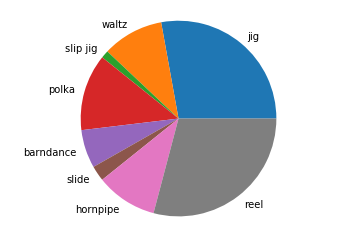

In [56]:
from collections import Counter
import matplotlib.pyplot as plt


keys = Counter(tune_types).keys() # equals to list(set(words))
vals = Counter(tune_types).values() # counts the elements' frequency

# Data to plot
labels = keys
sizes = vals
#colors = ['gold', 'yellowgreen', 'lightcoral', 'lightskyblue']
#explode =   # explode 1st slice
 
# Plot
plt.pie(sizes, labels=labels) #colors=colors,
        #autopct='%1.1f%%', shadow=True, startangle=140)
 
plt.axis('equal')
plt.show()

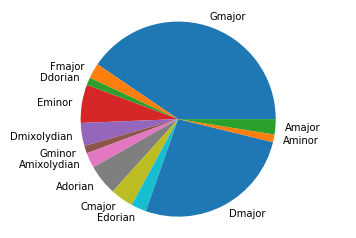

In [7]:
keys = Counter(tune_modes).keys() # equals to list(set(words))
vals = Counter(tune_modes).values() # counts the elements' frequency

# Data to plot
labels = keys
sizes = vals
#colors = ['gold', 'yellowgreen', 'lightcoral', 'lightskyblue']
#explode =   # explode 1st slice
 
# Plot
plt.pie(sizes, labels=labels) #colors=colors,
        #autopct='%1.1f%%', shadow=True, startangle=140)
 
plt.axis('equal')
plt.show()

In [ ]:
# From here I am working to wrap common types of searches I need with the thesessionDB class.

In [8]:
class dict_output(object):
    def __init__(self, file_name, method):
        self.file_obj = open(file_name, method)
    def __enter__(self):
        return self.file_obj
    def __exit__(self, type, value, traceback):
        print("Exception has been handled")
        self.file_obj.close()
        return True

In [47]:
import sqlite3

def dict_factory(cursor, row):
    d = {}
    for idx, col in enumerate(cursor.description):
        d[col[0]] = row[idx]
    return d

class QueryFormat():
    '''
    Context manager to provide a sqlite cursor to a database, which will return query data in json format by default.
    '''
    
    def __init__(self,db,json=True):
        self.db = db
        self.json = json
        
    def __enter__(self,json=True):
        if json: # should figure out how to make this a wrapper
            db.conn.row_factory = dict_factory
            self.cursor = db.conn.cursor()
        else:
            self.cursor = db.cur
        
        return self.cursor
    
    def __exit__(self,*args):
        # reset format
        db.conn.row_factory = sqlite3.Row
               

def tunesFromAlias(fragment,json=True):
    
    # split the fragment on white space
    words = fragment.split()
    
    # join words in the query with wildcards to catch more with SQL LIKE
    querystr = '%' + '%'.join(words) + '%'
    
    # Find all matches for the fragment in the alias table
    #db.cur.execute("SELECT tune_id FROM aliases WHERE alias LIKE '%"+fragment+"%'")
    db.cur.execute("SELECT tune_id FROM aliases WHERE alias LIKE '"+querystr+"'")
    q = db.cur.fetchall()  # fetch all the results of the query

    tune_ids = [x[0] for x in q]

    # find all unique ids
    unique_ids = {x for x in tune_ids}
    
    query = "SELECT * FROM tunes WHERE tune_id IN ({0})".format(', '.join(x for x in unique_ids))

    # switch to json format for query and restore
    with QueryFormat(json) as c:
    
        c.execute(query)

        q2 = c.fetchall()
    
    return q2

tunesFromAlias('silver spear')

[{'meter': u'4/4',
  'mode': u'Dmajor',
  'name': u'Silver Spear, The',
  'rhythm': u'reel',
  'tune_id': u'182'},
 {'meter': u'4/4',
  'mode': u'Adorian',
  'name': u'New Mown Meadows, The',
  'rhythm': u'reel',
  'tune_id': u'2706'}]

In [10]:
def aliasesForTune(tune_id):
    '''
    Returns all known aliases of a given tune
    '''
    
    # Find all matches for the fragment in the alias table
    db.cur.execute("SELECT alias FROM aliases WHERE tune_id=?",[tune_id])
    q = db.cur.fetchall()
    
    return [x[0] for x in q]
aliasesForTune(u'1555')

[u"Dick Cosgrove's",
 u'Dick Cosgroves',
 u'Old Yellow Tinker, The',
 u"W'ere Be Da Fiddle?",
 u'Yellow Haired Tinker, The',
 u'Yellow Tinker, The']

In [33]:
def settingsOfTune(tune_id,json=True):
    '''
    Returns all known aliases of a given tune
    '''
    
    # switch to json format for query and restore
    with QueryFormat(json) as c:
    
        # Find all matches for the fragment in the alias table
        c.execute("SELECT * FROM settings WHERE tune_id=?",[tune_id])
        q = c.fetchall()
    
    return q
settingsOfTune(u'1555')

[{'abc': u'EAAG EGDG|EA~A2 fAeA|EAAG EDEF|1 G2BG =cGBG:|2 GABd dBGB||\r\nA2eA fAeA|fAeA dBGB|A2eA fAeA|d2BG DGBG|\r\nA2eA fAeA|fAeA dBGB|~e3f ~g3e|d2BG DGBG||',
  'bars': None,
  'date': u'2003-03-31 03:27:23',
  'meter': u'4/4',
  'mode': u'Amixolydian',
  'name': u'Drunken Tinker, The',
  'rhythm': u'reel',
  'setting_id': u'1555',
  'structure': None,
  'tune_id': u'1555',
  'user': u'Dr. Dow'},
 {'abc': u'EAAG EGDG|EA~A2 fAeA|EAAG EDEF|1 G2DG B,GDG:|2 GFGA BcdB||\r\nA2eA fAeA|fAeA dBGB|A2gA fAeA|d2BG EFGB|\r\nA2eA fAeA|fAeA dBGB|~e3f ~g3e|d2BG EFGB|',
  'bars': None,
  'date': u'2013-05-25 13:06:25',
  'meter': u'4/4',
  'mode': u'Amixolydian',
  'name': u'Drunken Tinker, The',
  'rhythm': u'reel',
  'setting_id': u'21585',
  'structure': None,
  'tune_id': u'1555',
  'user': u'Werner Zipperer'},
 {'abc': u'|:EAAG EGDG|EA A2 fAeA|EAAG EDEF| G2BG =cGBG| \r\nEAAG EGDG|EA A2 fAeA|EAAG EDEF|GABd dBGB||\r\n|:A2eA fAeA|fAeA dBGB|A2eA fAeA|d2BG DGBG|\r\nA2eA fAeA|fAeA dBGB|e3f g3e|d2BG DG

In [34]:
import sqlite3


def recordingsOfTune(tune_id,json=True):
    '''
    Returns all recordings of a given tune.
    '''
    
    # switch to json format for query and restore
    with QueryFormat(json) as c:
    
        c.execute("SELECT * FROM recorded_tunes WHERE tune_id=?",[tune_id])
        
        q = c.fetchall()

    return q

recordingsOfTune(u'1555',json=True)

[{'artist': u'Altan',
  'id': u'3481',
  'number': 1,
  'recording_id': u'194',
  'recording_name': u'Altan: Live',
  'track': 2,
  'tune_id': u'1555',
  'tune_name': u'Drunken Tinker, The'},
 {'artist': u'Athena Tergis',
  'id': u'8083',
  'number': 2,
  'recording_id': u'2696',
  'recording_name': u'A Letter Home',
  'track': 7,
  'tune_id': u'1555',
  'tune_name': u'Drunken Tinker, The'},
 {'artist': u'Brendan Bulger, Marty Fahey And Kathleen Gavin',
  'id': u'14891',
  'number': 2,
  'recording_id': u'839',
  'recording_name': u'Music At The House',
  'track': 6,
  'tune_id': u'1555',
  'tune_name': u'Drunken Tinker, The'},
 {'artist': u'Eugene Lambe',
  'id': u'39156',
  'number': 1,
  'recording_id': u'2822',
  'recording_name': u'Trip To Fanore',
  'track': 4,
  'tune_id': u'1555',
  'tune_name': u'Drunken Tinker, The'},
 {'artist': u'Finbarr Dwyer',
  'id': u'40589',
  'number': 1,
  'recording_id': u'1725',
  'recording_name': u'Best Of Finbarr Dwyer',
  'track': 9,
  'tune_id

In [96]:
# Dummmy tune entry for when a 
gan_ainm = {'tune_id':None,'name':u'Gan Ainm','rhythm':None,'meter':None,'mode':None}

def setsWithTune(tune_id,json=True):
    '''
    Return all recorded sets of tunes. Returns A list of sets by tune, and by recording information
    '''
    
    if json: # should figure out how to make this a wrapper
        db.conn.row_factory = dict_factory
        c = db.conn.cursor()
    else:
        c = db.cur

    # switch to json format for query and restore
    with QueryFormat(json) as c:
        
        tune_recs = recordingsOfTune(tune_id)

        set_recs = [] 
        set_tunes = []

        for rec in tune_recs:
            #print rec['recording_id'], rec['track']

            c.execute("SELECT * FROM recorded_tunes WHERE recording_id=? AND track=?",[rec['recording_id'],rec['track']])

            q = c.fetchall()
            #print q
            tune_ids = [x['tune_id'] for x in q]

            tunes = []
            for tid in tune_ids:
                try: # if tune_id valid
                    tmp = int(tid)
                    c.execute("SELECT * FROM tunes WHERE tune_id=?",[tid])
                    q2 = c.fetchone()
                    tunes.append(q2)
                except:
                    tunes.append(gan_ainm)

            set_recs.append(q)
            set_tunes.append(tunes)
    
    return set_tunes, set_recs
    
st,sr = setsWithTune(u'1555',json=True)

st[3]

[{'meter': u'4/4',
  'mode': u'Amixolydian',
  'name': u'Drunken Tinker, The',
  'rhythm': u'reel',
  'tune_id': u'1555'},
 {'meter': u'4/4',
  'mode': u'Dmajor',
  'name': u'Convenience, The',
  'rhythm': u'reel',
  'tune_id': u'226'}]

In [97]:
# Example Stats on a tunes relative position in a set

tune_name = 'silver spear'

# Check that we find the tune we want
q = tunesFromAlias(tune_name)
print q[0]

tune_id = q[0]['tune_id']
sets_by_tune, sets_by_recording = setsWithTune(tune_id,json=True)

print len(sets_by_tune), ' recorded sets found'

{'mode': u'Dmajor', 'meter': u'4/4', 'tune_id': u'182', 'rhythm': u'reel', 'name': u'Silver Spear, The'}
171  recorded sets found


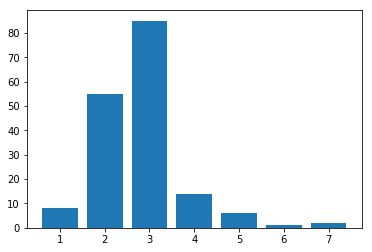

In [113]:
set_lengths = [len(x) for x in sets_by_tune]
set_lengths

import matplotlib.pyplot as plt
from collections import Counter

# Create your list
x = range(10)
x.append(1)

# Use a Counter to count the number of instances in x
c = Counter(set_lengths)

plt.bar(c.keys(), c.values())
plt.show()

In [175]:
def tunesBeforeAndAfter(tune_id, sets):
    
    tunes_before = []
    tunes_after = []
    position = []
    
    for aset in sets:
        #print aset
        before = None
        after = None
        for i,tune in enumerate(aset):
            #print tune
            if tune['tune_id'] == tune_id:
                if i > 0: # if not the first tune
                    before = aset[i-1]
                if i < len(aset)-1: # if not the last tune
                    after = aset[i+1]
                
                break
        
        # classify the tune as first, middle, last or only
        if before is None and after is None:
            pos = 'only'
        elif before is None:
            pos = 'first'
        elif after is None:
            pos = 'last'
        else: 
            pos = 'middle'
                
        tunes_before.append(before)
        tunes_after.append(after)
        position.append(pos)
                    
    return tunes_before,tunes_after,position

def tunesInSetWith(tune_id, sets):
    
    tunes = []
    
    for aset in sets:
        #print aset
        for tune in aset:
            #print tune
            if tune['tune_id'] == tune_id:
                pass
            else:
                tunes.append(tune)
    return tunes
             
#tunesInSetWith(tune_id,sets_by_tune)

tunes_before,tunes_after,tune_pos = tunesBeforeAndAfter(tune_id,sets_by_tune)
tunes_before

[{'meter': u'4/4',
  'mode': u'Gmajor',
  'name': u'Happy Man, The',
  'rhythm': u'reel',
  'tune_id': u'2122'},
 {'meter': u'4/4',
  'mode': u'Dmajor',
  'name': u'Boyne Hunt, The',
  'rhythm': u'reel',
  'tune_id': u'142'},
 None,
 None,
 {'meter': u'4/4',
  'mode': u'Gmajor',
  'name': u"S'iomadh Rud A Chunnaic Mi",
  'rhythm': u'reel',
  'tune_id': u'5478'},
 {'meter': u'4/4',
  'mode': u'Gmajor',
  'name': u'New Copperplate, The',
  'rhythm': u'reel',
  'tune_id': u'887'},
 {'meter': u'4/4',
  'mode': u'Bminor',
  'name': u'Musical Priest, The',
  'rhythm': u'reel',
  'tune_id': u'73'},
 {'meter': u'4/4',
  'mode': u'Dmajor',
  'name': u'Athol Brose',
  'rhythm': u'strathspey',
  'tune_id': u'1919'},
 None,
 None,
 None,
 None,
 None,
 None,
 {'meter': u'4/4',
  'mode': u'Gmajor',
  'name': u'Atlantic Wave, The',
  'rhythm': u'reel',
  'tune_id': u'962'},
 {'meter': u'4/4',
  'mode': u'Gmajor',
  'name': u'Bird In The Bush, The',
  'rhythm': u'reel',
  'tune_id': u'629'},
 {'meter

In [100]:
print len(tunes_before), len(tunes_after), len(sets_by_tune)

171 171 171


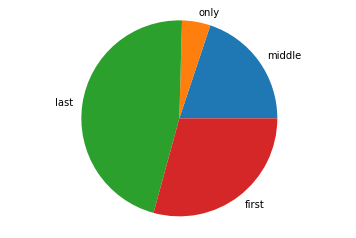

In [176]:
# Plot the distribution tune position

f,ax = plt.subplots(1,1)


keys = Counter(tune_pos).keys() # equals to list(set(words))
vals = Counter(tune_pos).values() # counts the elements' frequency

# Data to plot
labels = keys
sizes = vals
#colors = ['gold', 'yellowgreen', 'lightcoral', 'lightskyblue']
#explode =   # explode 1st slice
 
# Plot
ax.pie(sizes, labels=labels) #colors=colors,
        #autopct='%1.1f%%', shadow=True, startangle=140)
 
ax.axis('equal')


plt.show()

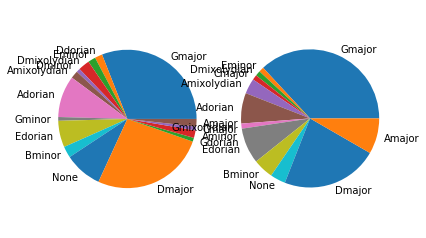

In [101]:
# Plot the distribution tune modes that are played with

f,(ax1,ax2) = plt.subplots(1,2)

data = []

for x in tunes_before:
    if x is not None:
        data.append(x['mode'])

keys = Counter(data).keys() # equals to list(set(words))
vals = Counter(data).values() # counts the elements' frequency

# Data to plot
labels = keys
sizes = vals
#colors = ['gold', 'yellowgreen', 'lightcoral', 'lightskyblue']
#explode =   # explode 1st slice
 
# Plot
ax1.pie(sizes, labels=labels) #colors=colors,
        #autopct='%1.1f%%', shadow=True, startangle=140)
 
ax1.axis('equal')

data = []

for x in tunes_after:
    if x is not None:
        data.append(x['mode'])

keys = Counter(data).keys() # equals to list(set(words))
vals = Counter(data).values() # counts the elements' frequency

# Data to plot
labels = keys
sizes = vals
#colors = ['gold', 'yellowgreen', 'lightcoral', 'lightskyblue']
#explode =   # explode 1st slice
 
# Plot
ax2.pie(sizes, labels=labels) #colors=colors,
        #autopct='%1.1f%%', shadow=True, startangle=140)
 
ax2.axis('equal')
plt.show()

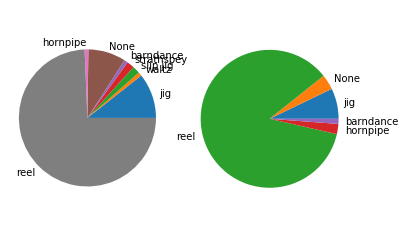

In [102]:
# Plot the distribution tune modes that are played with

f,(ax1,ax2) = plt.subplots(1,2)

data = []

for x in tunes_before:
    if x is not None:
        data.append(x['rhythm'])

keys = Counter(data).keys() # equals to list(set(words))
vals = Counter(data).values() # counts the elements' frequency

# Data to plot
labels = keys
sizes = vals
#colors = ['gold', 'yellowgreen', 'lightcoral', 'lightskyblue']
#explode =   # explode 1st slice
 
# Plot
ax1.pie(sizes, labels=labels) #colors=colors,
        #autopct='%1.1f%%', shadow=True, startangle=140)
 
ax1.axis('equal')

data = []

for x in tunes_after:
    if x is not None:
        data.append(x['rhythm'])

keys = Counter(data).keys() # equals to list(set(words))
vals = Counter(data).values() # counts the elements' frequency

# Data to plot
labels = keys
sizes = vals
#colors = ['gold', 'yellowgreen', 'lightcoral', 'lightskyblue']
#explode =   # explode 1st slice
 
# Plot
ax2.pie(sizes, labels=labels) #colors=colors,
        #autopct='%1.1f%%', shadow=True, startangle=140)
 
ax2.axis('equal')
plt.show()

In [169]:
import pandas as pd

def displayUniqueTuneInfo(tune_query,mode=None,rhythm=None,meter=None,tune_list=None):
    tunes = []
    for x in tune_query:
        if x is not None:
            tunes.append(x)

    df = pd.DataFrame(tunes)

    gb = df.groupby('tune_id')['tune_id']
    #gan_ainm = {'tune_id':None,'name':u'Gan Ainm','rhythm':None,'meter':None,'mode':None}

    df = df.drop_duplicates()
    df.index = df.tune_id

    df = df.sort_index()

    s = gb.count()

    s.sort_index()
    df['count'] = s 

    df = df.sort_values('count',ascending=False)

    return df[['name','rhythm','mode','count']]

In [170]:
# print a list of tunes played before (by count)
displayUniqueTuneInfo(tunes_before)

,name,rhythm,mode,count
tune_id,,,,
629,"Bird In The Bush, The",reel,Gmajor,5.0
72,"Merry Blacksmith, The",reel,Dmajor,5.0
98,"Sally Gardens, The",reel,Gmajor,4.0
2706,"New Mown Meadows, The",reel,Adorian,3.0
73,"Musical Priest, The",reel,Bminor,2.0
75,Miss McLeod's,reel,Gmajor,2.0
142,"Boyne Hunt, The",reel,Dmajor,2.0
2406,Tom Clancy's,reel,Dmajor,2.0
221,"Earl's Chair, The",reel,Dmajor,2.0


In [172]:
# print a list of tunes played after (by count)
displayUniqueTuneInfo(tunes_after)

,name,rhythm,mode,count
tune_id,,,,
141,"Humours Of Tulla, The",reel,Gmajor,5.0
605,Greig's Pipes,reel,Gmajor,4.0
98,"Sally Gardens, The",reel,Gmajor,3.0
75,Miss McLeod's,reel,Gmajor,3.0
12798,"Dublin, The",jig,Gmajor,3.0
44,"High, The",reel,Amixolydian,2.0
556,Sweeney's Buttermilk,reel,Bminor,2.0
2706,"New Mown Meadows, The",reel,Adorian,2.0
72,"Merry Blacksmith, The",reel,Dmajor,2.0


In [ ]:
#import pyabc
from pyabc import *
import json
import numpy as np

import os
import sqlite3  # this is the module that binds to SQLite
import pandas as pd  # you'll see why we can use this later

from progress import progress

https://thesession.org/api

Formats
JSON	?format=json
XML	?format=xml
RSS	?format=rss
Endpoints
The following lists are available in multiple formats e.g. /tunes/new?format=json or /recordings/search?q=altan&format=rss

By default, 10 items will be returned in a list. You can request up to 50 items by appending &perpage= e.g. /tunes/new?format=json&perpage=35

If you request an individual item, e.g. /tunes/27?format=xml, you will get back the details for that item and any comments that have been posted to it.

In [ ]:
# setup database

DBFILE = 'thesession.db'  # this will be our database
BASEDIR = os.getcwd() + '/sqlite3'  # os.path.abspath(os.path.dirname(__file__))
DBPATH = os.path.join(BASEDIR, DBFILE)

# we may need to delete the existing file first
if os.path.exists(DBPATH):
    os.remove(DBPATH)

# open a connection to the database for this tutorial
conn = sqlite3.connect(DBPATH)

# get a cursor to the database
cur = conn.cursor()

In [ ]:
def get_thesession_jsons():
    import os, json
    #if not os.path.isfile("tunes.json"):
    import sys, urllib
    for f in ['tunes','recodings','aliases','events','sessions']:
        url = 'https://raw.githubusercontent.com/adactio/TheSession-data/master/json/'+f+'.json'
        print("Downloading "+f+" database from %s..." % url)
        try:
            urllib.urlretrieve(url, 'json/'+f+'.json')
        except AttributeError:
            import urllib.request
            urllib.request.urlretrieve(url, 'json/'+f+'.json')
    #return json.loads(open('tunes.json', 'rb').read().decode('utf8'))
    
#get_thesession_jsons()

In [ ]:
json_tunes = json.loads(open('json/tunes.json', 'rb').read().decode('utf8'))
json_recordings = json.loads(open('json/recordings.json', 'rb').read().decode('utf8'))
json_aliases = json.loads(open('json/aliases.json', 'rb').read().decode('utf8'))
json_events = json.loads(open('json/events.json', 'rb').read().decode('utf8'))
json_sessions = json.loads(open('json/sessions.json', 'rb').read().decode('utf8'))

In [ ]:
# unicode
print json_tunes[1]['name']

In [ ]:
n_test = 10

In [ ]:
json_tunes[41]

In [ ]:
# From tunes.json

# users 
try:
    cur.execute('DROP TABLE users')
    #conn.commit()
except:
    pass

cur.execute('''CREATE TABLE users (
    user TEXT PRIMARY KEY
)''')
conn.commit()

# tunes
try:
    cur.execute('DROP TABLE tunes')
    #conn.commit()
except:
    pass

cur.execute('''CREATE TABLE tunes (
    tune_id TEXT PRIMARY KEY,
    name TEXT NOT NULL,
    rhythm TEXT NOT NULL,
    meter TEXT NOT NULL,
    mode TEXT NOT NULL
)''')
conn.commit()

# settings
try:
    cur.execute('DROP TABLE settings')
    #conn.commit()
except:
    pass

cur.execute('''CREATE TABLE settings (
    setting_id TEXT PRIMARY KEY,
    tune_id TEXT NOT NULL REFERENCES tunes ON UPDATE CASCADE ON DELETE CASCADE,
    abc  TEXT,
    date TEXT NOT NULL,
    user TEXT NOT NULL REFERENCES users on UPDATE CASCADE ON DELETE CASCADE,
    name TEXT NOT NULL,
    rhythm TEXT NOT NULL,
    meter TEXT NOT NULL,
    mode TEXT NOT NULL,
    bars INTEGER,
    structure TEXT
)''')
conn.commit()

In [ ]:
# Insert entries from tunes.json
N = 1000
for i,jj in enumerate(json_tunes[:N]): 
    
    # Fill missing with None
    keys = ['setting','tune','abc','date','username','name','type','meter','mode']
    j = {}   
    for x in keys:
        try:
            j.update({x:jj[x]})
        except:
            j.update({x:None})
    
    # Check if user is new, if so add to table
    cur.execute('SELECT * FROM users WHERE (user=?)', [j['username']])
    entry = cur.fetchone()
    if entry is None:
        cur.execute('INSERT INTO users VALUES (?)', [j['username']])
        
    # Check if tune is new, if so add to table
    cur.execute('SELECT * FROM tunes WHERE (tune_id=?)', [j['tune']])
    entry = cur.fetchone()
    if entry is None:
        row = [j['tune'],j['name'],j['type'],j['meter'],j['mode']]
        cur.execute('INSERT INTO tunes VALUES (?,?,?,?,?)', row)

    row = [j['setting'],j['tune'],j['abc'],j['date'],j['username'],j['name'],j['type'],j['meter'],j['mode']]
    cur.execute('INSERT INTO settings VALUES (?,?,?,?,?,?,?,?,?,NULL,NULL)',row)
    progress(i+1,N,'Transfering tune settings from JSON to SQL.')
    
conn.commit()  # you must commit for it to become permanent


In [ ]:
cur.execute('SELECT * FROM users')
cur.fetchall()  # fetch all the results of the query

In [ ]:
cur.execute('SELECT * FROM tunes')
cur.fetchall()  # fetch all the results of the query

In [ ]:
cur.execute('SELECT setting_id, tune_id, date, user FROM settings')
cur.fetchall()  # fetch all the results of the query

In [ ]:
# from aliases.json

# Create aliases table
try:
    cur.execute('DROP TABLE aliases')
    #conn.commit()
except:
    pass

cur.execute('''CREATE TABLE aliases (
    alias_id INTEGER PRIMARY KEY,
    alias TEXT NOT NULL,
    name TEXT NOT NULL,
    tune_id NOT NULL REFERENCES tunes ON UPDATE CASCADE ON DELETE CASCADE
)''')
conn.commit()

In [ ]:
# insert entries from aliases.json
N = 1000
cur.execute('SELECT MAX(alias_id) from aliases')
try:
    startid = int(cur.fetchone()[0])+1
except:
    startid = 0
        
for i,j in enumerate(json_aliases[:N]):
    keys = ['alias','name','tune_id']
    jj = {}   
    for x in keys:
        try:
            jj.update({x:j[x]})
        except:
            jj.update({x:None})
    
    row = [startid+i,jj['alias'],jj['name'],jj['tune_id']]
    cur.execute('INSERT INTO aliases VALUES (?,?,?,?)',row)
    progress(i+1,N,'Transferrring aliases from JSON to SQL.')
conn.commit()

In [ ]:
cur.execute('SELECT MAX(alias_id) from aliases')
startid = int(cur.fetchone()[0])+1
startid

In [ ]:
cur.execute('SELECT * FROM aliases')
cur.fetchall()  # fetch all the results of the query

In [ ]:
# from recordings.json

#artists
try:
    cur.execute('DROP TABLE artists')
    #conn.commit()
except:
    pass

cur.execute('''CREATE TABLE artists (
    artist TEXT PRIMARY KEY
)''')
conn.commit()

# recordings  (albums)
try:
    cur.execute('DROP TABLE recordings')
    #conn.commit()
except:
    pass

cur.execute('''CREATE TABLE recordings (
    recording_id TEXT PRIMARY KEY,
    recording_name TEXT NOT NULL,
    artist TEXT REFERENCES artists ON UPDATE CASCADE ON DELETE CASCADE
)''')
conn.commit()

# recorded tunes
try:
    cur.execute('DROP TABLE recorded_tunes')
    #conn.commit()
except:
    pass

cur.execute('''CREATE TABLE recorded_tunes (
    id TEXT PRIMARY KEY,
    recording_id TEXT REFERENCES recordings ON UPDATE CASCADE ON DELETE CASCADE,
    recording_name TEXT NOT NULL,
    artist TEXT REFERENCES artists ON UPDATE CASCADE ON DELETE CASCADE,
    track INTEGER NOT NULL,
    number INTEGER NOT NULL,
    tune_name TEXT, 
    tune_id NOT NULL REFERENCES tunes ON UPDATE CASCADE ON DELETE CASCADE
    
)''')
conn.commit()

In [ ]:
# Insert entries from recordings.json
N = 1000
for i,j in enumerate(json_recordings[:N]): 
    
    keys = ['id','recording','artist','track','number','tune','tune_id']
    jj = {}   
    for x in keys:
        try:
            jj.update({x:j[x]})
        except:
            jj.update({x:None})
    
    # Check if user is new, if so add to table
    cur.execute('SELECT * FROM artists WHERE (artist=?)', [jj['artist']])
    entry = cur.fetchone()
    if entry is None:
        cur.execute('INSERT INTO artists VALUES (?)', [jj['artist']])
        
    # Check if tune is new, if so add to table
    cur.execute('SELECT * FROM recordings WHERE (recording_id=?)', [jj['id']])
    entry = cur.fetchone()
    if entry is None:
        row = [j['id'],j['recording'],j['artist']]
        cur.execute('INSERT INTO recordings VALUES (?,?,?)', row)

    row = [i,jj['id'],jj['recording'],jj['artist'],int(jj['track']),int(jj['number']),jj['tune'],jj['tune_id']]
    cur.execute('INSERT INTO recorded_tunes VALUES (?,?,?,?,?,?,?,?)',row)
    progress(i+1,N,'Transferring recordings from JSON to SQL.')
    
conn.commit()  # you must commit for it to become permanent
    #cur.rowcount  # tells you how many rows written, sometimes, it's quirky

In [ ]:
cur.execute('SELECT * FROM recordings')
cur.fetchall()  # fetch all the results of the query

In [ ]:
# from events.json
try:
    cur.execute('DROP TABLE events')
    #conn.commit()
except:
    pass

cur.execute('''CREATE TABLE events (
    event_id TEXT PRIMARY KEY,
    address TEXT,
    area TEXT,
    country TEXT,
    dtend TEXT,
    dtstart TEXT,
    event_name TEXT,
    latitude TEXT,
    logitude TEXT,
    town TEXT,
    venue TEXT
)''')
conn.commit()

In [ ]:
progress?

In [ ]:
N = 1000
for i,j in enumerate(json_events[:N]):    

    keys = ['id','address','area','country','dtend','dtstart','event','latitude','longitude','town','venue']
    row = [ None for x in range(len(keys))]
    
    for x in  range(len(keys)):
        try:
            row[x] = j[keys[x]]
        except:
            pass
    #row = [j['id'],j['address'],j['area'],j['country'],j['dtend'],j['dtstart'],j['event'],
    #      j['latitude'],j['longitude'],j['town'],j['venue']]
    cur.execute('INSERT INTO events VALUES (?,?,?,?,?,?,?,?,?,?,?)',row)
    conn.commit()  # you must commit for it to become permanent
    #cur.rowcount  # tells you how many rows written, sometimes, it's quirky
    progress(i+1,N,'Transfering events from JSON to SQL.')

In [ ]:
cur.execute('SELECT * FROM events')
cur.fetchall()  # fetch all the results of the query

In [ ]:
# from sessions.json
try:
    cur.execute('DROP TABLE sessions')
    #conn.commit()
except:
    pass

cur.execute('''CREATE TABLE sessions (
    session_id TEXT PRIMARY KEY,
    address TEXT,
    area TEXT,
    country TEXT,
    date TEXT,
    latitude TEXT,
    logitude TEXT,
    name TEXT,
    town TEXT
)''')
conn.commit()

In [ ]:
json_sessions[1000]

In [ ]:
N = 1000
for i,j in enumerate(json_sessions[:N]):    

    keys = ['id','address','area','country','date','latitude','longitude','name','town']
    row = [ None for x in range(len(keys))]
    
    for x in  range(len(keys)):
        try:
            row[x] = j[keys[x]]
        except:
            pass
       
    #row = [j['id'],j['address'],j['area'],j['country'],j['date'],
    #      j['latitude'],j['longitude'],j['name'],j['town']]
    
    cur.execute('INSERT INTO sessions VALUES (?,?,?,?,?,?,?,?,?)',row)
    #cur.rowcount  # tells you how many rows written, sometimes, it's quirky
    progress(i+1,N,'Transfering sessions from JSON to SQL.')
conn.commit()  # you must commit for it to become permanent

In [ ]:
cur.execute('SELECT * FROM sessions')
cur.fetchall()  # fetch all the results of the query